In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer

import gensim

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torch.nn.functional as F



from transformers import BertTokenizer, BertForSequenceClassification, pipeline

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import (
    Dense, Dropout, Embedding, Conv1D, GlobalMaxPooling1D, 
    LSTM, GlobalMaxPool1D
)
from tensorflow.keras.optimizers import Adam

/usr/local/lib/python3.10/dist-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-05-18 09:04:30.514124: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-18 09:04:30.524262: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register f

## Read train and test

In [2]:
train_df = pd.read_csv("train.csv")
test_df  = pd.read_csv("test.csv")

y_str = train_df["labels"].values
y_list = [list(map(int, s.split())) for s in y_str]
y = np.array(y_list)
num_classes = y.shape[1]

print("Треин =", train_df.shape)
print("тест  =", test_df.shape)
print("кол во классов =", num_classes)

Треин = (29568, 3)
тест  = (7392, 2)
кол во классов = 20


## EDA

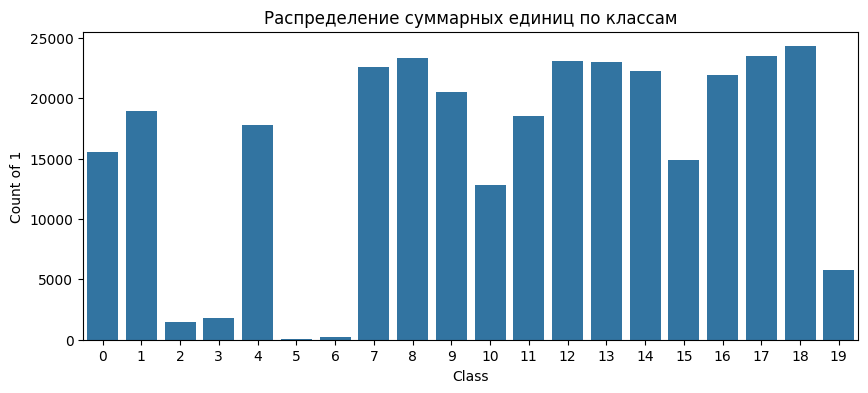

Min/Max кол-во 1 по классам: 99 / 24300
ID=0
TEXT= 15 января
Детская развлекательная программа
15-00 бесплатно
❗️
@
cafeotdyh
Кафе  ...
LABELS= [1 0 0 0 1 0 0 0 1 0 0 0 1 1 1 1 1 0 0 1]
---
ID=1
TEXT= 13 и 14 августа
Выходные в Меге
https://t.me/megaufa_official
Мегапарк ...
LABELS= [0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 1 1 0 0 1]
---
ID=2
TEXT= Йокнапатофа
Постановка Театр им. Маяковского
Билеты от 500 до 2000 р. ...
LABELS= [0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 1 0 0 1]
---


In [3]:
class_counts = y.sum(axis=0)
plt.figure(figsize=(10,4))
sns.barplot(x=np.arange(num_classes), y=class_counts)
plt.title("Распределение суммарных единиц по классам")
plt.xlabel("Class")
plt.ylabel("Count of 1")
plt.show()

print("Min/Max кол-во 1 по классам:", class_counts.min(), "/", class_counts.max())

# Примеры
for i in range(3):
    print(f"ID={train_df.loc[i, 'id']}")
    print("TEXT=", train_df.loc[i, 'text'][:80], "...")
    print("LABELS=", y[i])
    print("---")


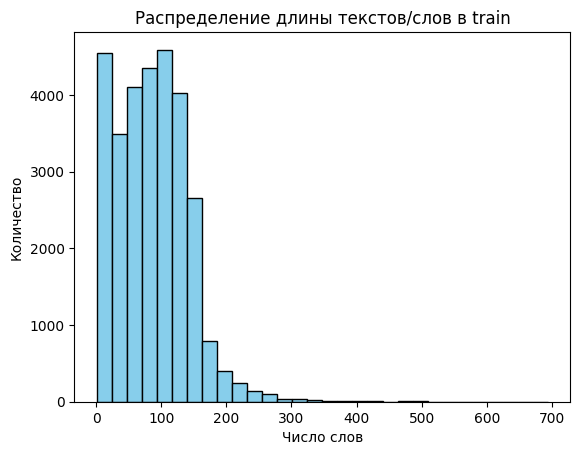

Средняя длина- 86.60619588744589
Медианная длина - 85.0


In [4]:
# посмотрим на длину текстов
text_len = train_df["text"].apply(lambda x: len(str(x).split()))
plt.hist(text_len, bins=30, color='skyblue', edgecolor='black')
plt.title("Распределение длины текстов/слов в train")
plt.xlabel("Число слов")
plt.ylabel("Количество")
plt.show()

print("Средняя длина-", text_len.mean())
print("Медианная длина -", text_len.median())

Выведем корреляцию между классами

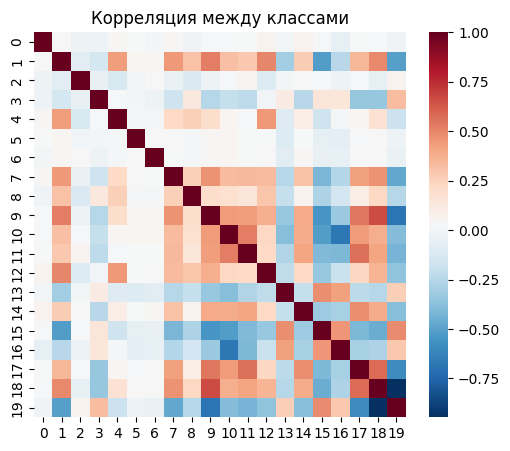

Число почти пустых текстов в train: 10


In [5]:
corr = np.corrcoef(y.T)
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=False, cmap="RdBu_r")
plt.title("Корреляция между классами")
plt.show()

# посмотрим кол-во почти пустых текстов
empty_texts = sum(train_df["text"].apply(lambda x: len(str(x).strip())<10))
print(f"Число почти пустых текстов в train: {empty_texts}")

### Выводы по EDA

1. **Распределение классов**  
   - Видим, что минимальное количество единиц в классе (класс под номером 5) – около 99, а максимальное (под номером 18) – 24300. Это говорит о существенном дисбалансе классов. Редкие классы могут ухудшать итоговый `f1_macro`, поэтому стоит уделить внимание способам балансировки (например генерация).
2. **Длина текстов**  
   - По анализу видно, что длина примерно 86 слов, медианная примерно 85 слов, но у некоторых текстов длина доходит до 300+ слов. Это говорит о "хвосте" длинных текстов.  
   - Большое число текстов имеет длину в диапазоне 50–150 слов.
3. **Содержимое текстов**  
   - Видны ссылки (https://), упоминания спецсимволов и т.д. Это важно учесть при очистке.
4. **Корреляция между классами**  
   - На тепловой карте видно что часть классов довольно сильно коррелирует (красные области выше 0.5), а некоторые пары, наоборот, заметно противоположны. Это может говорить нам о том, что при появлении одних меток часто встречаются и другие, а некоторые классы практически не сосуществуют в одном тексте. Для модели такие связи могут быть подсказкой, позволяя лучше определять сопутствующие классы.Или исключать маловероятные сочетания.
5. **Пустые/короткие тексты** 
   - Также было выведено число почти пустых текстов(определяли по своему порогу - 10). Возможно,стоит их заменить на специальный токен или удалить.

##  Очистка текста + обоснование для разных эмбеддингов.

In [6]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"https?://\S+", " ", text)
    text = re.sub(r"[^а-яёa-z0-9 ]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

train_df["clean_text"] = train_df["text"].apply(clean_text)
test_df["clean_text"]  = test_df["text"].apply(clean_text)

# проверка
print("Исходный текст:")
print(train_df.loc[0,"text"])
print("Очищенный текст:")
print(train_df.loc[0,"clean_text"])

Исходный текст:
15 января
Детская развлекательная программа
15-00 бесплатно
❗️
@
cafeotdyh
Кафе "Отдых"
📍
Запись обязательно +73472228532
Очищенный текст:
15 января детская развлекательная программа 15 00 бесплатно cafeotdyh кафе отдых запись обязательно 73472228532


### очистки под разные эмбеддинги

- **TF-IDF, W2V, CNN, RNN**:  
  В большинстве случаев важно привести текст к нижнему регистру, удалить ссылки, спецсимволы и т.д. Эти методы чувствительны к шуму, так как токенизация идет по словам, и лишние знаки могут раздробить слова или увеличить размер словаря. Поэтому `clean_text` удаляет неалфавитные символы (кроме цифр, если они важны), ссылки, лишние пробелы.
  
- **BERT-like**:  
  BERT-токенайзеры могут переваривать многие символы, но ссылки и мусор всt равно лучше убрать, чтобы модель не тратила эмбеддинги на лишние токены. При этом нет особой необходимости нормализовать тексты, потому что BERT внутренно использует WordPiece и умеет работать с подсловами. Но можемиспользовать `clean_text` для единобразия.

## Трейн/вал сплит и метрика

In [7]:
X_train, X_val, y_train, y_val = train_test_split(
    train_df["clean_text"], y, test_size=0.2, random_state=42
)
# метрика
def f1_for_val(y_true, y_pred):
    return f1_score(y_true, (y_pred>0.5).astype(int), average="macro")

print("треин:", len(X_train), "вал:", len(X_val))

треин: 23654 вал: 5914


## Модель 1 -TF-IDF +  Dense-сеть.

In [8]:
# для накопления лоссов
class HistoryContainer:
    def __init__(self):
        self.history = {
            "loss": [],
            "val_loss": []
        }

# ранняя остановка
class EarlyStopper:
    def __init__(self, patience=3, restore_best_weights=True, checkpoint_path="temp_model.pt"):
        self.patience = patience
        self.restore_best_weights = restore_best_weights
        self.checkpoint_path = checkpoint_path
        self.best_val_loss = float('inf')
        self.wait = 0
    
    def check(self, val_loss, model):
        if val_loss < self.best_val_loss:
            # улучшение
            self.best_val_loss = val_loss
            self.wait = 0
            # сохраним лучшую модель
            torch.save(model.state_dict(), self.checkpoint_path)
        else:
            self.wait += 1
        if self.wait >= self.patience:
            # ранняя остановка
            if self.restore_best_weights:
                model.load_state_dict(torch.load(self.checkpoint_path))
            return True
        return False

In [9]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [41]:
# tf idf
tfidf = TfidfVectorizer(max_features=5000)
tfidf.fit(X_train)

X_train_tfidf = tfidf.transform(X_train).toarray()
X_val_tfidf   = tfidf.transform(X_val).toarray()
X_test_tfidf  = tfidf.transform(test_df["clean_text"]).toarray()

# тензоры
X_train_tfidf_t = torch.tensor(X_train_tfidf, dtype=torch.float32)
y_train_t       = torch.tensor(y_train,       dtype=torch.float32)
X_val_tfidf_t   = torch.tensor(X_val_tfidf,   dtype=torch.float32)
y_val_t         = torch.tensor(y_val,         dtype=torch.float32)


class TfidfNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, output_dim=num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))  # multi-label => сигмоида
        return x

# модель и оптимизатор
tfidf_model = TfidfNet(input_dim=X_train_tfidf.shape[1])
tfidf_model.cuda()
optimizer = optim.Adam(tfidf_model.parameters(), lr=1e-3)
criterion = nn.BCELoss()

# для уменьшения lr при отсутствии улучшений
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1, verbose=1)

# колбеки
es_tfidf = EarlyStopper(patience=3, restore_best_weights=True, checkpoint_path="best_tfidf_model.pt")

# хранение лоссов
history_tfidf = HistoryContainer()

epochs = 15
batch_size = 32

def tfidf_batch_generator(X, Y, batch_size):
    perm = torch.randperm(len(X))
    X = X[perm]
    Y = Y[perm]
    for i in range(0, len(X), batch_size):
        yield X[i:i+batch_size], Y[i:i+batch_size]

for epoch in range(epochs):
    # train
    tfidf_model.train()
    train_loss_accum = 0.0
    
    for xb, yb in tfidf_batch_generator(X_train_tfidf_t.cuda(), y_train_t.cuda(), batch_size):
        optimizer.zero_grad()
        preds = tfidf_model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        
        train_loss_accum += loss.item() * len(xb)
    train_loss = train_loss_accum / len(X_train_tfidf_t)
    
    # val
    tfidf_model.eval()
    with torch.no_grad():
        val_preds = tfidf_model(X_val_tfidf_t.cuda())
        val_loss = criterion(val_preds, y_val_t.cuda()).item()
    
    history_tfidf.history["loss"].append(train_loss)
    history_tfidf.history["val_loss"].append(val_loss)
    
    print(f"Epoch {epoch+1}/{epochs} - loss: {train_loss:.4f} - val_loss: {val_loss:.4f}")
    

    scheduler.step(val_loss)
    

    should_stop = es_tfidf.check(val_loss, tfidf_model)
    if should_stop:
        print("Early stopping triggered!")
        break

# предикт на вал
tfidf_model.eval()
with torch.no_grad():
    p_val_tfidf = tfidf_model(torch.tensor(X_val_tfidf, dtype=torch.float32).cuda()).cpu().numpy()

print("TF-IDF Model F1:", f1_for_val(y_val, p_val_tfidf))

loss_tfidf = history_tfidf.history["loss"]
val_loss_tfidf = history_tfidf.history["val_loss"]

Epoch 1/15 - loss: 0.3163 - val_loss: 0.2333
Epoch 2/15 - loss: 0.2054 - val_loss: 0.2005
Epoch 3/15 - loss: 0.1724 - val_loss: 0.1877
Epoch 4/15 - loss: 0.1517 - val_loss: 0.1828
Epoch 5/15 - loss: 0.1368 - val_loss: 0.1816
Epoch 6/15 - loss: 0.1248 - val_loss: 0.1807
Epoch 7/15 - loss: 0.1152 - val_loss: 0.1828
Epoch 8/15 - loss: 0.1062 - val_loss: 0.1860
Epoch 9/15 - loss: 0.0941 - val_loss: 0.1863
Early stopping triggered!
TF-IDF Model F1: 0.8259750974436966


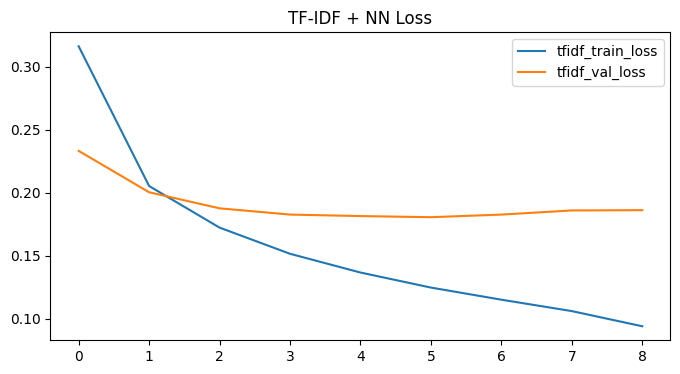

In [42]:
# график лоссов
plt.figure(figsize=(8,4))
plt.plot(loss_tfidf, label="tfidf_train_loss")
plt.plot(val_loss_tfidf, label="tfidf_val_loss")
plt.title("TF-IDF + NN Loss")
plt.legend()
plt.show()

## Модель 2 - W2V и NN 

In [12]:
def text_to_w2v_vector(text):
    words = text.split()
    vecs = []
    for w in words:
        if w in w2v_model.wv.key_to_index:
            vecs.append(w2v_model.wv[w])
    if len(vecs)==0:
        return np.zeros(w2v_model.vector_size)
    return np.mean(vecs, axis=0)

In [13]:
# применяем Word2Vec
all_texts_for_w2v = pd.concat([X_train, X_val, test_df["clean_text"]], ignore_index=True)
tokens_for_w2v = [txt.split() for txt in all_texts_for_w2v]
w2v_model = gensim.models.Word2Vec(tokens_for_w2v, vector_size=100, min_count=1, window=5)

X_train_w2v = np.array([text_to_w2v_vector(t) for t in X_train])
X_val_w2v   = np.array([text_to_w2v_vector(t) for t in X_val])
X_test_w2v  = np.array([text_to_w2v_vector(t) for t in test_df["clean_text"]])


X_train_w2v_t = torch.tensor(X_train_w2v, dtype=torch.float32)
X_val_w2v_t   = torch.tensor(X_val_w2v,   dtype=torch.float32)
y_train_t_w2v = torch.tensor(y_train,     dtype=torch.float32)
y_val_t_w2v   = torch.tensor(y_val,       dtype=torch.float32)

X_train_w2v_t = X_train_w2v_t.cuda()
X_val_w2v_t   = X_val_w2v_t.cuda()
y_train_t_w2v = y_train_t_w2v.cuda()
y_val_t_w2v   = y_val_t_w2v.cuda()


class W2VNet(nn.Module):
    def __init__(self, input_dim=100, hidden_dim=128, output_dim=num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))
        return x

w2v_nn_model = W2VNet().cuda()
optimizer_w2v = optim.Adam(w2v_nn_model.parameters(), lr=1e-3)
criterion = nn.BCELoss()

es_w2v = EarlyStopper(patience=3, restore_best_weights=True, checkpoint_path="best_w2v_model.pt")
scheduler_w2v = ReduceLROnPlateau(optimizer_w2v, mode='min', factor=0.5, patience=1, verbose=1)

history_w2v = HistoryContainer()

epochs = 15
batch_size = 32

def w2v_batch_gen(X, Y, bs=32):
    perm = torch.randperm(len(X))
    X = X[perm]
    Y = Y[perm]
    for i in range(0, len(X), bs):
        yield X[i:i+bs], Y[i:i+bs]

for epoch in range(epochs):
    w2v_nn_model.train()
    train_loss_accum = 0.0
    
    for xb, yb in w2v_batch_gen(X_train_w2v_t, y_train_t_w2v, batch_size):
        optimizer_w2v.zero_grad()
        preds = w2v_nn_model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer_w2v.step()
        
        train_loss_accum += loss.item() * len(xb)
    train_loss = train_loss_accum / len(X_train_w2v_t)
    
    # val
    w2v_nn_model.eval()
    with torch.no_grad():
        val_preds = w2v_nn_model(X_val_w2v_t)
        val_loss = criterion(val_preds, y_val_t_w2v).item()
    
    history_w2v.history["loss"].append(train_loss)
    history_w2v.history["val_loss"].append(val_loss)
    
    print(f"[Epoch {epoch+1}] w2v train_loss={train_loss:.4f}, val_loss={val_loss:.4f}")
    
    scheduler_w2v.step(val_loss)
    if es_w2v.check(val_loss, w2v_nn_model):
        print("EarlyStopping triggered for W2V!")
        break

# Лучшая модель
w2v_nn_model.load_state_dict(torch.load("best_w2v_model.pt"))
w2v_nn_model.eval()
with torch.no_grad():
    p_val_w2v = w2v_nn_model(X_val_w2v_t).cpu().numpy()

print("W2V NN Model F1:", f1_for_val(y_val, p_val_w2v))

[Epoch 1] w2v train_loss=0.3533, val_loss=0.3041
[Epoch 2] w2v train_loss=0.3019, val_loss=0.2844
[Epoch 3] w2v train_loss=0.2884, val_loss=0.2760
[Epoch 4] w2v train_loss=0.2805, val_loss=0.2691
[Epoch 5] w2v train_loss=0.2736, val_loss=0.2654
[Epoch 6] w2v train_loss=0.2692, val_loss=0.2617
[Epoch 7] w2v train_loss=0.2662, val_loss=0.2596
[Epoch 8] w2v train_loss=0.2632, val_loss=0.2560
[Epoch 9] w2v train_loss=0.2612, val_loss=0.2536
[Epoch 10] w2v train_loss=0.2581, val_loss=0.2516
[Epoch 11] w2v train_loss=0.2568, val_loss=0.2502
[Epoch 12] w2v train_loss=0.2544, val_loss=0.2490
[Epoch 13] w2v train_loss=0.2529, val_loss=0.2473
[Epoch 14] w2v train_loss=0.2516, val_loss=0.2449
[Epoch 15] w2v train_loss=0.2495, val_loss=0.2446
W2V NN Model F1: 0.7558069572931083


## CNN

In [ ]:
class CNNClassifier(nn.Module):
    def __init__(self, vocab_size=8000, emb_dim=64, num_filters=64, num_classes=num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim)
        self.conv1 = nn.Conv1d(in_channels=emb_dim, out_channels=num_filters, kernel_size=3)
        self.pool  = nn.AdaptiveMaxPool1d(1)
        self.fc = nn.Linear(num_filters, num_classes)
    def forward(self, x):
        # x: [batch_size, seq_len]
        emb = self.embedding(x)               
        emb = emb.permute(0, 2, 1)            
        c = torch.relu(self.conv1(emb))      
        pooled = self.pool(c).squeeze(-1)  
        logits = self.fc(pooled)        
        return torch.sigmoid(logits)

In [14]:
vocab_size = 8000
tokenizer_cnn = Tokenizer(num_words=vocab_size, oov_token="<UNK>")
tokenizer_cnn.fit_on_texts(X_train)

maxlen_cnn = 40

def seq_prepare(texts):
    seqs = tokenizer_cnn.texts_to_sequences(texts)
    return pad_sequences(seqs, maxlen=maxlen_cnn, padding="post")

X_train_seq_cnn = seq_prepare(X_train)
X_val_seq_cnn   = seq_prepare(X_val)
X_test_seq_cnn  = seq_prepare(test_df["clean_text"])

X_train_cnn_t = torch.tensor(X_train_seq_cnn, dtype=torch.long).cuda()
y_train_cnn_t = torch.tensor(y_train,         dtype=torch.float32).cuda()

X_val_cnn_t   = torch.tensor(X_val_seq_cnn,   dtype=torch.long).cuda()
y_val_cnn_t   = torch.tensor(y_val,           dtype=torch.float32).cuda()


cnn_model = CNNClassifier(
    vocab_size=vocab_size, 
    emb_dim=64, 
    num_filters=64, 
    num_classes=num_classes
).cuda()

optimizer_cnn = optim.Adam(cnn_model.parameters(), lr=1e-3)
criterion = nn.BCELoss()

es_cnn = EarlyStopper(patience=5, restore_best_weights=True, checkpoint_path="best_cnn_model.pt")
scheduler_cnn = ReduceLROnPlateau(optimizer_cnn, mode='min', factor=0.5, patience=1, verbose=1)

history_cnn = HistoryContainer()

epochs = 15
batch_size = 32

def cnn_batch_gen(X, Y, bs=32):
    perm = torch.randperm(len(X))
    X = X[perm]
    Y = Y[perm]
    for i in range(0, len(X), bs):
        yield X[i:i+bs], Y[i:i+bs]

for epoch in range(epochs):
    cnn_model.train()
    train_loss_accum = 0.0
    
    for xb, yb in cnn_batch_gen(X_train_cnn_t, y_train_cnn_t, batch_size):
        optimizer_cnn.zero_grad()
        preds = cnn_model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer_cnn.step()
        train_loss_accum += loss.item() * len(xb)
    
    train_loss = train_loss_accum / len(X_train_cnn_t)
    # validation
    cnn_model.eval()
    with torch.no_grad():
        val_preds = cnn_model(X_val_cnn_t)
        val_loss = criterion(val_preds, y_val_cnn_t).item()
    
    history_cnn.history["loss"].append(train_loss)
    history_cnn.history["val_loss"].append(val_loss)
    
    print(f"[Epoch {epoch+1}] CNN train_loss={train_loss:.4f}, val_loss={val_loss:.4f}")
    scheduler_cnn.step(val_loss)
    if es_cnn.check(val_loss, cnn_model):
        print("EarlyStopping triggered for CNN!")
        break

# загрузка лучшей модели
cnn_model.load_state_dict(torch.load("best_cnn_model.pt"))
cnn_model.eval()
with torch.no_grad():
    p_val_cnn = cnn_model(X_val_cnn_t).cpu().numpy()

print("CNN Model F1:", f1_for_val(y_val, p_val_cnn))


loss_cnn = history_cnn.history["loss"]
val_loss_cnn = history_cnn.history["val_loss"]

[Epoch 1] CNN train_loss=0.3405, val_loss=0.2986
[Epoch 2] CNN train_loss=0.2806, val_loss=0.2766
[Epoch 3] CNN train_loss=0.2546, val_loss=0.2674
[Epoch 4] CNN train_loss=0.2357, val_loss=0.2634
[Epoch 5] CNN train_loss=0.2204, val_loss=0.2576
[Epoch 6] CNN train_loss=0.2068, val_loss=0.2571
[Epoch 7] CNN train_loss=0.1946, val_loss=0.2591
[Epoch 8] CNN train_loss=0.1837, val_loss=0.2602
[Epoch 9] CNN train_loss=0.1688, val_loss=0.2587
[Epoch 10] CNN train_loss=0.1630, val_loss=0.2607
[Epoch 11] CNN train_loss=0.1556, val_loss=0.2607
EarlyStopping triggered for CNN!
CNN Model F1: 0.7659964636331086


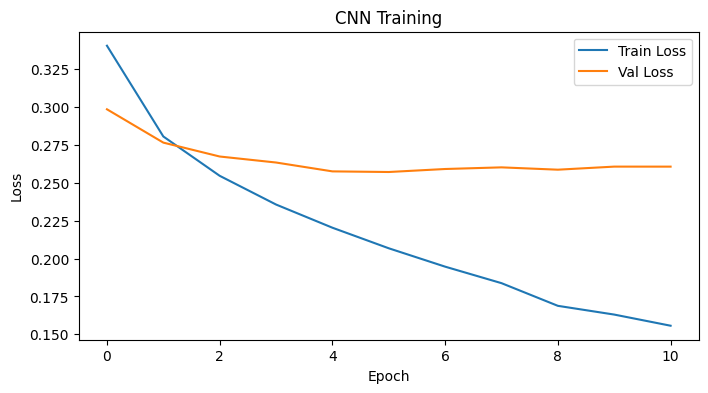

In [15]:
# график
plt.figure(figsize=(8,4))
plt.plot(history_cnn.history["loss"], label="Train Loss")
plt.plot(history_cnn.history["val_loss"], label="Val Loss")
plt.title("CNN Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## RNN (LSTM) с Embedding и свитч лосса

In [16]:
X_train_rnn_t = torch.tensor(X_train_seq_cnn, dtype=torch.long).cuda()
y_train_rnn_t = torch.tensor(y_train,         dtype=torch.float32).cuda()

X_val_rnn_t   = torch.tensor(X_val_seq_cnn,   dtype=torch.long).cuda()
y_val_rnn_t   = torch.tensor(y_val,           dtype=torch.float32).cuda()

class RNNModel(nn.Module):
    def __init__(self, vocab_size=8000, emb_dim=64, hidden_dim=64, num_classes=num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim)
        self.lstm = nn.LSTM(emb_dim, hidden_dim, batch_first=True)
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.fc = nn.Linear(hidden_dim, num_classes)
    def forward(self, x):
        # x- [batch, seq_len]
        emb = self.embedding(x)
        #output - [batch, seq_len, hidden_dim]
        output, (h, c) = self.lstm(emb)  

        output = output.permute(0, 2, 1)
        pooled = self.pool(output).squeeze(-1)
        logits = self.fc(pooled)
        return torch.sigmoid(logits)

rnn_model = RNNModel().cuda()


optimizer_rnn = optim.Adam(rnn_model.parameters(), lr=1e-3)
criterion_bce = nn.BCELoss()

es_rnn = EarlyStopper(patience=5, restore_best_weights=True, checkpoint_path="best_rnn_phase1.pt")

print("PHASE 1- bce loss")

epochs_phase1 = 15
batch_size = 32

for epoch in range(epochs_phase1):
    rnn_model.train()
    train_loss_accum = 0.0
    
    # batch gen
    perm = torch.randperm(len(X_train_rnn_t))
    X_shuf = X_train_rnn_t[perm]
    y_shuf = y_train_rnn_t[perm]
    
    for i in range(0, len(X_shuf), batch_size):
        xb = X_shuf[i:i+batch_size]
        yb = y_shuf[i:i+batch_size]
        optimizer_rnn.zero_grad()
        preds = rnn_model(xb)
        loss = criterion_bce(preds, yb)
        loss.backward()
        optimizer_rnn.step()
        train_loss_accum += loss.item() * len(xb)
    train_loss = train_loss_accum / len(X_train_rnn_t)
    
    # val
    rnn_model.eval()
    with torch.no_grad():
        val_preds = rnn_model(X_val_rnn_t)
        val_loss  = criterion_bce(val_preds, y_val_rnn_t).item()
    
    print(f"Phase1 - Epoch {epoch+1}/{epochs_phase1}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}")
    
    stop = es_rnn.check(val_loss, rnn_model)
    if stop:
        print("Early stop Phase1")
        break


def dice_loss_torch(y_true, y_pred, eps=1e-7):

    numerator = 2.0 * (y_true * y_pred).sum()
    denominator = (y_true + y_pred).sum() + eps
    return 1.0 - numerator / denominator


optimizer_rnn_2 = optim.Adam(rnn_model.parameters(), lr=1e-3)
es_rnn2 = EarlyStopper(patience=5, restore_best_weights=True, checkpoint_path="best_rnn_model.pt")

history_rnn_2 = HistoryContainer()

print("PHASE 2- dice_loss")
epochs_phase2 = 15
for epoch in range(epochs_phase2):
    rnn_model.train()
    train_loss_accum = 0.0
    
    perm = torch.randperm(len(X_train_rnn_t))
    X_shuf = X_train_rnn_t[perm]
    y_shuf = y_train_rnn_t[perm]
    
    for i in range(0, len(X_shuf), batch_size):
        
        
        xb = X_shuf[i:i+batch_size]
        yb = y_shuf[i:i+batch_size]
        optimizer_rnn_2.zero_grad()
        preds = rnn_model(xb)
        
        
        loss = dice_loss_torch(yb, preds)
        loss.backward()
        optimizer_rnn_2.step()
        train_loss_accum += loss.item() * len(xb)
        
    train_loss = train_loss_accum / len(X_train_rnn_t)
    
    # val
    rnn_model.eval()
    val_preds = rnn_model(X_val_rnn_t)
    val_loss  = dice_loss_torch(y_val_rnn_t, val_preds).item()
    
    history_rnn_2.history["loss"].append(train_loss)
    history_rnn_2.history["val_loss"].append(val_loss)
    
    print(f"Phase2 - Epoch {epoch+1}/{epochs_phase2}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}")
    
    if es_rnn2.check(val_loss, rnn_model):
        print("Early stop Phase2")
        break

# Предикт
rnn_model.eval()
with torch.no_grad():
    p_val_rnn = rnn_model(X_val_rnn_t).cpu().numpy()

print("RNN (two-phase) F1:", f1_for_val(y_val, p_val_rnn))


loss_rnn_2 = history_rnn_2.history["loss"]
val_loss_rnn_2 = history_rnn_2.history["val_loss"]

PHASE 1- bce loss
Phase1 - Epoch 1/15: train_loss=0.3786, val_loss=0.3220
Phase1 - Epoch 2/15: train_loss=0.3065, val_loss=0.2970
Phase1 - Epoch 3/15: train_loss=0.2808, val_loss=0.2827
Phase1 - Epoch 4/15: train_loss=0.2620, val_loss=0.2737
Phase1 - Epoch 5/15: train_loss=0.2458, val_loss=0.2657
Phase1 - Epoch 6/15: train_loss=0.2317, val_loss=0.2607
Phase1 - Epoch 7/15: train_loss=0.2188, val_loss=0.2574
Phase1 - Epoch 8/15: train_loss=0.2072, val_loss=0.2578
Phase1 - Epoch 9/15: train_loss=0.1970, val_loss=0.2574
Phase1 - Epoch 10/15: train_loss=0.1873, val_loss=0.2575
Phase1 - Epoch 11/15: train_loss=0.1790, val_loss=0.2579
Phase1 - Epoch 12/15: train_loss=0.1703, val_loss=0.2618
Phase1 - Epoch 13/15: train_loss=0.1628, val_loss=0.2630
Phase1 - Epoch 14/15: train_loss=0.1555, val_loss=0.2655
Early stop Phase1
PHASE 2- dice_loss
Phase2 - Epoch 1/15: train_loss=0.0998, val_loss=0.1144
Phase2 - Epoch 2/15: train_loss=0.0895, val_loss=0.1109
Phase2 - Epoch 3/15: train_loss=0.0827, val_

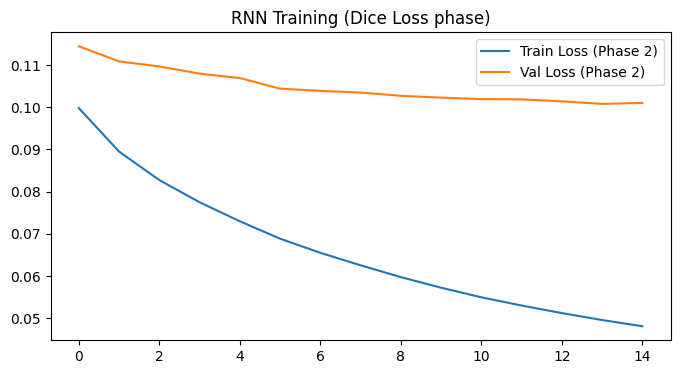

In [17]:
plt.figure(figsize=(8,4))
plt.plot(history_rnn_2.history["loss"], label="Train Loss (Phase 2)")
plt.plot(history_rnn_2.history["val_loss"], label="Val Loss (Phase 2)")
plt.title("RNN Training (Dice Loss phase)")
plt.legend()
plt.show()

## BERT 

In [ ]:
from transformers import BertForSequenceClassification, BertTokenizer
from transformers import get_linear_schedule_with_warmup
from tqdm.auto import tqdm

In [18]:


def encode_bert_pt(texts, tokenizer, max_len=256):
    if hasattr(texts, "tolist"):
        texts = texts.tolist()
    enc = tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=max_len,
        return_tensors="pt"
    )
    return enc["input_ids"], enc["attention_mask"]

bert_name = "cointegrated/rubert-tiny"
bert_tokenizer = BertTokenizer.from_pretrained(bert_name)

bert_model = BertForSequenceClassification.from_pretrained(
    bert_name,
    num_labels=num_classes,
    problem_type="multi_label_classification"
).cuda()

X_train_bert_ids_pt, X_train_bert_mask_pt = encode_bert_pt(X_train, bert_tokenizer)
X_val_bert_ids_pt,   X_val_bert_mask_pt   = encode_bert_pt(X_val,   bert_tokenizer)

y_train_bert_t = torch.tensor(y_train, dtype=torch.float32)
y_val_bert_t   = torch.tensor(y_val,   dtype=torch.float32)

# optimizer и LR warmup
optimizer_bert = optim.AdamW(bert_model.parameters(), lr=2e-5)
epochs = 15
batch_size = 4

train_size = len(X_train_bert_ids_pt)
total_steps = train_size // batch_size * epochs
warmup_steps = (train_size // batch_size) * 1
scheduler_bert = get_linear_schedule_with_warmup(
    optimizer_bert, 
    num_warmup_steps=warmup_steps, 
    num_training_steps=total_steps
)

criterion = nn.BCEWithLogitsLoss()

history_bert = HistoryContainer()
es_bert = EarlyStopper(patience=3, restore_best_weights=True, checkpoint_path="best_bert_model.pt")

def bert_batch_gen(X_ids, X_mask, Y, bs=4):
    perm = torch.randperm(len(X_ids))
    X_ids = X_ids[perm]
    X_mask= X_mask[perm]
    Y     = Y[perm]
    for i in range(0, len(X_ids), bs):
        yield X_ids[i:i+bs], X_mask[i:i+bs], Y[i:i+bs]

print("Starting BERT training...")

for epoch in range(epochs):
    # TRAIN
    bert_model.train()
    train_loss_accum = 0.0

    loop = tqdm(
        bert_batch_gen(X_train_bert_ids_pt, X_train_bert_mask_pt, y_train_bert_t, batch_size),
        total=(len(X_train_bert_ids_pt) // batch_size),
        desc=f"Epoch {epoch+1}/{epochs}",          # подпись слева
        unit="batch",                              # единица измерения
        leave=False                                # не оставлять прогресс после завершения
    )
    for xb_ids, xb_mask, yb in loop:
        xb_ids  = xb_ids.cuda()
        xb_mask = xb_mask.cuda()
        yb      = yb.cuda()

        optimizer_bert.zero_grad()
        outputs = bert_model(input_ids=xb_ids, attention_mask=xb_mask)
        logits = outputs.logits
        loss = criterion(logits, yb)
        loss.backward()
        optimizer_bert.step()
        scheduler_bert.step()

        train_loss_accum += loss.item() * xb_ids.size(0)


        loop.set_postfix(train_loss=train_loss_accum / ((loop.n + 1) * batch_size))

    train_loss = train_loss_accum / len(X_train_bert_ids_pt)

    # val
    bert_model.eval()
    with torch.no_grad():
        val_out = bert_model(
            input_ids=X_val_bert_ids_pt.cuda(),
            attention_mask=X_val_bert_mask_pt.cuda()
        )
        val_logits = val_out.logits
        val_loss = criterion(val_logits, y_val_bert_t.cuda()).item()

    history_bert.history["loss"].append(train_loss)
    history_bert.history["val_loss"].append(val_loss)
    print(f"Epoch {epoch+1}/{epochs}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}")

    if es_bert.check(val_loss, bert_model):
        print("Early stop for BERT!")
        break

# предикт
bert_model.eval()
with torch.no_grad():
    val_out = bert_model(
        input_ids=X_val_bert_ids_pt.cuda(),
        attention_mask=X_val_bert_mask_pt.cuda()
    )
    val_logits = val_out.logits
    # сигмоида
    p_val_bert = torch.sigmoid(val_logits).cpu().numpy()

print("BERT model F1:", f1_for_val(y_val, p_val_bert))

loss_bert = history_bert.history["loss"]
val_loss_bert = history_bert.history["val_loss"]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting BERT training...


Epoch 1/15: train_loss=0.4002, val_loss=0.2677


Epoch 2/15: train_loss=0.2436, val_loss=0.2228


Epoch 3/15: train_loss=0.2131, val_loss=0.2081


Epoch 4/15: train_loss=0.1945, val_loss=0.1916


Epoch 5/15: train_loss=0.1759, val_loss=0.1781


Epoch 6/15: train_loss=0.1605, val_loss=0.1697


Epoch 7/15: train_loss=0.1483, val_loss=0.1634


Epoch 8/15: train_loss=0.1387, val_loss=0.1586


Epoch 9/15: train_loss=0.1307, val_loss=0.1559


Epoch 10/15: train_loss=0.1240, val_loss=0.1518


Epoch 11/15: train_loss=0.1183, val_loss=0.1532


Epoch 12/15: train_loss=0.1136, val_loss=0.1502


Epoch 13/15: train_loss=0.1103, val_loss=0.1486


Epoch 14/15: train_loss=0.1074, val_loss=0.1476


Epoch 15/15: train_loss=0.1060, val_loss=0.1476
BERT model F1: 0.8197419419627072


In [21]:
1

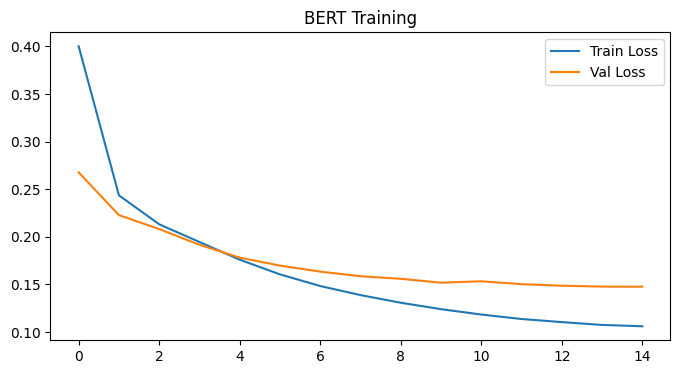

In [19]:
plt.figure(figsize=(8,4))
plt.plot(history_bert.history["loss"], label="Train Loss")
plt.plot(history_bert.history["val_loss"], label="Val Loss")
plt.title("BERT Training")
plt.legend()
plt.show()

## Сравнение результатов

In [45]:
results = {}
results["TF-IDF + NN"] = f1_for_val(y_val, p_val_tfidf)
results["W2V + NN"]    = f1_for_val(y_val, p_val_w2v)
results["CNN"]         = f1_for_val(y_val, p_val_cnn)
results["RNN (2-phase)"]= f1_for_val(y_val, p_val_rnn)
results["BERT"]        = f1_for_val(y_val, p_val_bert)

for k,v in results.items():
    print(k, "F1=", v)

TF-IDF + NN F1= 0.8259750974436966
W2V + NN F1= 0.7558069572931083
CNN F1= 0.7659964636331086
RNN (2-phase) F1= 0.7558513880688664
BERT F1= 0.8197419419627072


## Генерация синтетики

In [24]:
generator = pipeline(
    "text-generation",
    model="sberbank-ai/rugpt3small_based_on_gpt2",
    tokenizer="sberbank-ai/rugpt3small_based_on_gpt2",
    device=0
)

np.random.seed(42)
n_synthetic = 1000

original_indices = np.random.choice(len(X_train), size=n_synthetic, replace=True)
synthetic_texts = []
synthetic_labels = []

for idx in original_indices:
    # массив меток
    base_lbl = y_train[idx]
    
    # делаем строку для промпта
    lbl_str = " ".join(map(str, base_lbl))
    
    prompt = (
        f"Метки: {lbl_str}. "
        f"Напиши короткий связный текст по-русски (2-3 предложения) на эту тему:\n"
    )
    
    # генерация
    out = generator(
        prompt,
        max_length=50,
        num_return_sequences=1,
        do_sample=True,
        top_k=50,
        top_p=0.95
    )
    
    # берем сгенерированный текст
    gen_text = out[0]["generated_text"]
    
    
    
    synthetic_texts.append(gen_text)
    synthetic_labels.append(base_lbl)

# собираем в df
synthetic_df = pd.DataFrame({"text": synthetic_texts})
synthetic_df["clean_text"] = synthetic_df["text"].apply(clean_text)
synthetic_y = np.array(synthetic_labels)

# соединяем с нашими данными
aug_X = pd.concat([X_train, synthetic_df["clean_text"]], ignore_index=True)
aug_y = np.concatenate([y_train, synthetic_y], axis=0)

print("размер:", len(aug_X))

Device set to use cuda:0
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


размер: 24654


In [25]:
#сохраняем сгенерированные данные
label_str_list = [" ".join(map(str, row)) for row in synthetic_y]

synthetic_df["labels"] = label_str_list

synthetic_df.to_csv("synthetic_data.csv", index=False, encoding="utf-8")


## Дообучение RNN c синтетическими

In [31]:
# перетокенизируем
aug_seq = seq_prepare(aug_X)
# тот же seq_prepare
aug_seq_t = torch.tensor(aug_seq, dtype=torch.long).cuda()
aug_y_t   = torch.tensor(aug_y,   dtype=torch.float32).cuda()



rnn_model_aug = RNNModel(
    vocab_size=vocab_size,
    emb_dim=64,
    hidden_dim=64,
    num_classes=num_classes
).cuda()

# дообучаем, подгружаем
rnn_model_aug.load_state_dict(torch.load("best_rnn_model.pt"))

optimizer_aug = torch.optim.Adam(rnn_model_aug.parameters(), lr=1e-3)
criterion_aug = nn.BCELoss()

cb_rnn_aug = EarlyStopper(patience=1, restore_best_weights=True, checkpoint_path="best_rnn_aug_model.pt")


epochs_aug = 15
batch_size = 32

def aug_batch_gen(X, Y, bs=32):
    perm = torch.randperm(len(X))
    X = X[perm]
    Y = Y[perm]
    for i in range(0, len(X), bs):
        yield X[i:i+bs], Y[i:i+bs]

for epoch in range(epochs_aug):
    rnn_model_aug.train()
    train_loss_accum = 0.0
    
    for xb, yb in aug_batch_gen(aug_seq_t, aug_y_t, batch_size):
        optimizer_aug.zero_grad()
        preds = rnn_model_aug(xb)
        loss = criterion_aug(preds, yb)
        loss.backward()
        optimizer_aug.step()
        train_loss_accum += loss.item() * len(xb)
    train_loss = train_loss_accum / len(aug_seq_t)
    
    print(f"[Epoch {epoch+1}/{epochs_aug}] aug_train_loss={train_loss:.4f}")
    
    # ранняя ост.
    stopped = cb_rnn_aug.check(train_loss, rnn_model_aug)
    if stopped:
        print("EarlyStopping сработал на синтетике!")
        break

# загружаем веса
rnn_model_aug.load_state_dict(torch.load("best_rnn_aug_model.pt"))
rnn_model_aug.eval()

# оценка на вал
X_val_seq_cnn_t = torch.tensor(X_val_seq_cnn, dtype=torch.long).cuda()
with torch.no_grad():
    p_val_rnn_aug_t = rnn_model_aug(X_val_seq_cnn_t).cpu().numpy()


[Epoch 1/15] aug_train_loss=0.2655
[Epoch 2/15] aug_train_loss=0.1812
[Epoch 3/15] aug_train_loss=0.1573
[Epoch 4/15] aug_train_loss=0.1437
[Epoch 5/15] aug_train_loss=0.1336
[Epoch 6/15] aug_train_loss=0.1258
[Epoch 7/15] aug_train_loss=0.1195
[Epoch 8/15] aug_train_loss=0.1142
[Epoch 9/15] aug_train_loss=0.1086
[Epoch 10/15] aug_train_loss=0.1040
[Epoch 11/15] aug_train_loss=0.0997
[Epoch 12/15] aug_train_loss=0.0953
[Epoch 13/15] aug_train_loss=0.0917
[Epoch 14/15] aug_train_loss=0.0882
[Epoch 15/15] aug_train_loss=0.0847


In [33]:
# оценка
p_val_rnn_aug = p_val_rnn_aug_t

print("RNN AUG F1 на валидации:", f1_for_val(y_val, p_val_rnn_aug))

# Сравнение
f1_before = f1_for_val(y_val, p_val_rnn)
f1_after  = f1_for_val(y_val, p_val_rnn_aug)
print(f"До генерации: RNN F1={f1_before:.4f}, после={f1_after:.4f}")
if f1_after>f1_before:
    print("Качество улучшилось после добавления синт. данных")
else:
    print("Качество не улучшилось или ухудшилось")

RNN AUG F1 на валидации: 0.7702856730368529
До генерации: RNN F1=0.7559, после=0.7703
Качество улучшилось после добавления синт. данных


### Анализ результатов с синтетическими данными

Мы добавили 1000 синтетически сгенерированных примеров при помощи `sberbank-ai/rugpt3small_based_on_gpt2`.  
- **До генерации**: качество (F1 на валидации) было ~`0.7559`.  
- **После добавления**: качество стало ~`0.7703`.  

сгенерированные тексты стали дополнительным источником вариативности и помогли сбалансировать/обогатить обучающую выборку. 


## ансамбль

In [46]:
ensemble_val = (p_val_tfidf + p_val_w2v + p_val_cnn + p_val_rnn + p_val_bert) / 5.0
f1_ensemble = f1_for_val(y_val, ensemble_val)
print("F1=", f1_ensemble)

results["ENSEMBLE"] = f1_ensemble

best_model_name = None
best_val_f1 = -1
for name, val_f1 in results.items():
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_model_name = name

print("\nВсе F1 на валидации:")
for k, v in results.items():
    print(f"  {k}: F1={v:.4f}")
print(f"\nBest model or ensemble on val: {best_model_name} (F1={best_val_f1:.4f})")

F1= 0.7947720143378498

Все F1 на валидации:
  TF-IDF + NN: F1=0.8260
  W2V + NN: F1=0.7558
  CNN: F1=0.7660
  RNN (2-phase): F1=0.7559
  BERT: F1=0.8197
  ENSEMBLE: F1=0.7948

Best model or ensemble on val: TF-IDF + NN (F1=0.8260)


In [47]:
# предикты tf idf
X_test_tfidf_t = torch.tensor(X_test_tfidf, dtype=torch.float32).cuda()
tfidf_model.eval()
with torch.no_grad():
    p_test_tfidf_t = tfidf_model(X_test_tfidf_t).cpu().numpy()
p_test_tfidf = p_test_tfidf_t

#w2v
X_test_w2v_t = torch.tensor(X_test_w2v, dtype=torch.float32).cuda()
w2v_nn_model.eval()
with torch.no_grad():
    p_test_w2v_t = w2v_nn_model(X_test_w2v_t).cpu().numpy()
p_test_w2v = p_test_w2v_t

# cnn
X_test_seq_cnn_t = torch.tensor(X_test_seq_cnn, dtype=torch.long).cuda()
cnn_model.eval()
with torch.no_grad():
    p_test_cnn_t = cnn_model(X_test_seq_cnn_t).cpu().numpy()
p_test_cnn = p_test_cnn_t

#rnn (two-phase)
rnn_model.eval()
with torch.no_grad():
    p_test_rnn_t = rnn_model(X_test_seq_cnn_t).cpu().numpy()
p_test_rnn = p_test_rnn_t

# bert
test_ids_bert_pt, test_mask_bert_pt = encode_bert_pt(test_df["clean_text"], bert_tokenizer, max_len=64)
test_ids_bert_pt  = test_ids_bert_pt.cuda()
test_mask_bert_pt = test_mask_bert_pt.cuda()

bert_model.eval()
with torch.no_grad():
    test_logits_bert = bert_model(input_ids=test_ids_bert_pt, attention_mask=test_mask_bert_pt).logits
p_test_bert = torch.sigmoid(test_logits_bert).cpu().numpy()

In [48]:
if best_model_name == "ENSEMBLE":
    p_test_ensemble = (p_test_tfidf +p_test_w2v +p_test_cnn +p_test_rnn +p_test_bert) / 5.0
    final_test_pred = p_test_ensemble
elif best_model_name == "BERT":
    final_test_pred = p_test_bert
elif best_model_name == "RNN (2-phase)":
    final_test_pred = p_test_rnn
elif best_model_name == "CNN":
    final_test_pred = p_test_cnn
elif best_model_name == "W2V + NN":
    final_test_pred = p_test_w2v
else:
    final_test_pred = p_test_tfidf

In [49]:
p_test_bin = (final_test_pred > 0.5).astype(int)

# собираем submission
submission_list = []
for idx_val, row_pred in zip(test_df["id"], p_test_bin):
    row_str = " ".join(map(str, row_pred))
    submission_list.append((idx_val, row_str))

sub_df = pd.DataFrame(submission_list, columns=["id","labels"])
sub_df.to_csv("submission.csv", index=False)
print(f"Сабмит 'submission.csv' сохранен, выбрана модель: {best_model_name} (F1={best_val_f1:.4f})")

Сабмит 'submission.csv' сохранен, выбрана модель: TF-IDF + NN (F1=0.8260)
